In [1]:
using PorousMaterials
using PyPlot
using DataFrames
using CSV

In [2]:
xe_atomic_mass = read_atomic_masses()[:Xe] # in g / mol

131.293

In [3]:
path_to_exptl_isotherms = joinpath("data", "exptl_xe_isotherms")
path_to_sim_isotherms = joinpath("data","sim_xe_isotherms")

"data/sim_xe_isotherms"

In [19]:
crystal_names = ["SBMOF-1", "CC3", "Ni-MOF-74", "HKUST-1", "SBMOF-2", "Co-formate",
    "FMOF-Cu", "MOF-505", "Activated-Carbon", "COF-103"]

mof_to_marker = Dict("SBMOF-1" => "o", "CC3" => ">", "Ni-MOF-74" => "<", "HKUST-1" => "*", "SBMOF-2" => "H", 
    "Co-formate" => "^", "FMOF-Cu" => "s", "MOF-505" => "v",
    "Activated-Carbon" => "d", "COF-103" => "8")

mof_to_color = Dict(zip(crystal_names, ["C$i" for i = 1:length(crystal_names)]))# TODO MAKE UNIQUE!

Dict{String,String} with 10 entries:
  "Ni-MOF-74"        => "C3"
  "SBMOF-2"          => "C5"
  "FMOF-Cu"          => "C7"
  "CC3"              => "C2"
  "Activated-Carbon" => "C9"
  "COF-103"          => "C10"
  "SBMOF-1"          => "C1"
  "HKUST-1"          => "C4"
  "MOF-505"          => "C8"
  "Co-formate"       => "C6"

In [5]:
df_mof = Dict{String, DataFrame}()

Dict{String,DataFrame} with 0 entries

In [6]:
# create a dictionary to store the crystal density values
ρ_crystal = Dict{String, Float64}()

# find crystal density using PorousMaterials.jl
for crystal_name in crystal_names
    if crystal_name != "Activated-Carbon"
        if crystal_name == "COF-102" || crystal_name == "COF-103"
            framework = Framework(crystal_name * ".cif")
            strip_numbers_from_atom_labels!(framework)
            ρ_crystal[crystal_name] = crystal_density(framework) # kg/m³
        else    
            framework = Framework(crystal_name * ".cssr")
            strip_numbers_from_atom_labels!(framework)
            ρ_crystal[crystal_name] = crystal_density(framework) # kg/m³
        end
    else
        ρ_crystal[crystal_name] = 500.0 # kg/m³
    end
end

# df_ρ_crystal = DataFrame(xtal=collect(keys(ρ_crystal)), rho=collect(values(ρ_crystal)))
# df_ρ_crystal[!, :color] = map(m -> mof_to_color[m], df_ρ_crystal[:, :xtal])
# sort!(df_ρ_crystal, :rho)

# ρ_crystal # kg/m³

In [7]:
xe_isotherms = Dict{String, DataFrame}()

for crystal_name in crystal_names
    isotherm_filename = joinpath(path_to_exptl_isotherms, crystal_name, "Xe.csv")
    # some mofs have a hysteresis curve that needs to be removed from the data manually
    if crystal_name == "FMOF-Cu" 
        xe_isotherms[crystal_name] = CSV.read(isotherm_filename; copycols=true)
        deleterows!(xe_isotherms[crystal_name], 15:24)
    elseif crystal_name == "SBMOF-2"
        xe_isotherms[crystal_name] = CSV.read(isotherm_filename; copycols=true)
        deleterows!(xe_isotherms[crystal_name], 30:39)
    elseif crystal_name == "COF-103"
        sim_isotherm_filename = joinpath(path_to_sim_isotherms, crystal_name*".csv")
        cof_isotherm = CSV.read(sim_isotherm_filename; copycols=true)
        xe_isotherms[crystal_name] = cof_isotherm[:,[Symbol("pressure (bar)"), Symbol("⟨N⟩ (mmol/g)")]]
    else
        xe_isotherms[crystal_name] = CSV.read(isotherm_filename) 
    end
end

In [8]:
# Define what the desired common units are for the data
common_pressure_units = Symbol("Pressure (bar)") 
common_loading_units = Symbol("Loading (mol/m³)")

# Define a dictionary with conversion factors.
pressure_conversion = Dict{Symbol, Float64}()
loading_conversion = Dict{Symbol, Float64}()

# pressure conversions to bar
pressure_conversion[Symbol("pressure (bar)")] = 1.0 # (1 bar) / (1 bar)
pressure_conversion[Symbol("P(bar)")] = 1.0 # (1 bar) / (1 bar)
# pressure_conversion[Symbol("fugacity (bar)")] = 1.0 # (1 bar) / (1 bar)
pressure_conversion[Symbol("P(mbar)")] = 1 / 1000 # (1 bar) / (1000 mbar)
pressure_conversion[Symbol("P(kPa)")] = 1 / 100 # (1 bar) / (100 kPa)
pressure_conversion[Symbol("P(torr)")] = 1 / 750.062 # (1 bar) / (750.062 torr)
pressure_conversion[Symbol("P(atm)")] = 1 / 0.986923 # (1 bar) / (0.986923 atm)

# loading conversions to mol/kg
# these conversion factors will put the quantity into mmol/g which can then be multiplied by the crystal density 
loading_conversion[Symbol("L(mmol/g)")] = 1.0 # (1 mol/kg) / (1 mmol/g)
loading_conversion[Symbol("⟨N⟩ (mmol/g)")] = 1.0 # (1 mol/kg) / (1 mmol/g)
loading_conversion[Symbol("L(ccSTP/g)")] = 1 / 22.4 # (cc STP /g) (1000 g /kg) (1 mol/ 22.4 L STP) (1 L / 1000 cc)
loading_conversion[Symbol("L(cm3STP/g)")] =1 / 22.4
# [(% mass) / 100 g Xe / g MOF](1 mol /MW_Xe g) (1000 g /1 kg)
loading_conversion[:PercentMass] = 1000.0 / xe_atomic_mass / 100.0
# this one is an exception where xtal density not needed
loading_conversion[Symbol("L(mol/L)")] = 1000.0 # (mol / L)(1000 L / m3)

1000.0

In [9]:
for mof in keys(xe_isotherms)
    # loop over columns in the adsorption isotherm DataFrame
    for col_name in names(xe_isotherms[mof])
        # convert pressure units to bar
        if col_name in keys(pressure_conversion)
            xe_isotherms[mof][!, common_pressure_units] = xe_isotherms[mof][!, col_name] * pressure_conversion[col_name]
        # convert loading units to mol/m3
        elseif col_name in keys(loading_conversion)
            if col_name == Symbol("L(mol/L)")
                xe_isotherms[mof][!, common_loading_units] = xe_isotherms[mof][!, col_name] * loading_conversion[col_name]
            else 
                xe_isotherms[mof][!, common_loading_units] = xe_isotherms[mof][!, col_name] * loading_conversion[col_name] * ρ_crystal[mof] 
            end 
        else  
            print(mof, " has units with unknow conversion: ",col_name,"\n") 
        end
    end
end

SBMOF-1 has units with unknow conversion: Weight(mg)


In [10]:
# fit Langmuir adsorption model
params_langmuir = Dict{String, DataFrame}()
for mof in keys(xe_isotherms)
    params_langmuir[mof] = fit_adsorption_isotherm(copy(xe_isotherms[mof]), common_pressure_units,
        common_loading_units, :langmuir)
end

In [11]:
keys(params_langmuir)

Base.KeySet for a Dict{String,DataFrame} with 10 entries. Keys:
  "Ni-MOF-74"
  "SBMOF-2"
  "FMOF-Cu"
  "CC3"
  "Activated-Carbon"
  "COF-103"
  "SBMOF-1"
  "HKUST-1"
  "MOF-505"
  "Co-formate"

In [12]:
df_crystal = Dict{String,DataFrame}()

for name in crystal_names
    df_crystal[name] = DataFrame(xtal=name, rho=ρ_crystal[name], 
            Langmuir_M=params_langmuir[name][:,Symbol("M")], Langmuir_K=params_langmuir[name][:,Symbol("K")])
end

In [13]:
df_crystal["CC3"]

,xtal,rho,Langmuir_M,Langmuir_K
,String,Float64,Float64,Float64
1,CC3,958.585,2630.2,7.57403


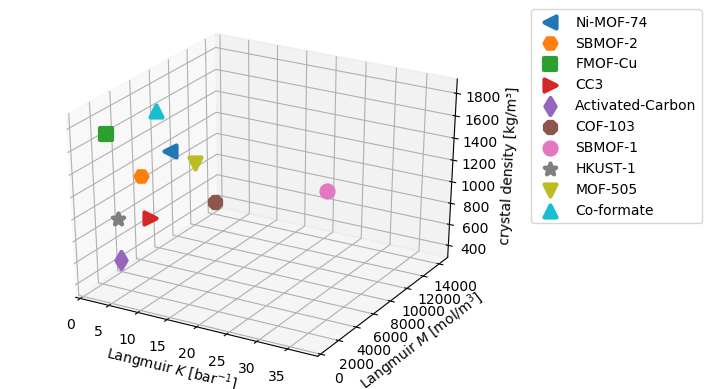

PyObject <matplotlib.legend.Legend object at 0x7f8d0059e7b8>

In [21]:
# figure(figsize=(5,5))
figure()
title("Material Space")
for mof_name in keys(df_crystal)
    scatter3D(df_crystal[mof_name][!, :Langmuir_K], df_crystal[mof_name][!, :Langmuir_M], 
        df_crystal[mof_name][!, :rho], 
        label=mof_name, marker=mof_to_marker[mof_name], s=75, clip_on=false, lw=3)
end

xlabel(L"Langmuir $K$ [bar$^{-1}$]")
ylabel(L"Langmuir $M$ [mol/m$^3$]")
zlabel("crystal density [kg/m³]")

ylim(ymin=0.0)
xlim(xmin=0.0)
legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
# show()

# need to set colormap to indicate which have better tankage fractions
# savefig("Langmuir_Material_Space_Plot.png", format="png")

In [15]:
# ? scatter3D()

In [16]:
# ? scatter